In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
import logging
import matplotlib.pyplot as plt
import torch
from pykeen.datasets import PathDataset
from pykeen.pipeline import pipeline
from statistics import mean, median
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from pyvis.network import Network
from ipywidgets import interact
import ipywidgets as widgets
from itertools import chain
from pathlib import Path
from rich import print

from utils import prepare_for_visualization

## Settings

In [4]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

pd.set_option("display.float_format", lambda x: "%.5f" % x)
logging.getLogger("pykeen").setLevel(logging.CRITICAL)

## Loading data

In [5]:
DATASET_PATH = Path("data/FB15k237")

In [6]:
dataset = PathDataset(
    DATASET_PATH / "train.tsv",
    DATASET_PATH / "test.tsv",
    DATASET_PATH / "valid.tsv",
)

g = nx.DiGraph()
g.add_edges_from([(h, t, {"title": r}) for h, r, t in dataset.training.triples])

## Visualization

In [7]:
_list_nodes = list(g.nodes)


@interact
def visualize(
    nodes=widgets.SelectMultiple(
        options=list(g.nodes), rows=10, value=[_list_nodes[0]]
    ),
    k=[0, 1, 2, 3],
    toggle_physics=False,
):
    filtered = set(
        chain(
            *[
                list(nx.single_source_shortest_path_length(g, n, cutoff=k))
                for n in nodes
            ]
        )
    )
    # print(filtered)
    subgraph = nx.subgraph_view(g, filter_node=lambda x: x in filtered)
    nt = Network(
        "500px", "500px", directed=True, notebook=True, cdn_resources="in_line"
    )
    nt.inherit_edge_colors(False)
    nt.from_nx(subgraph)
    nt.toggle_physics(toggle_physics)
    display(nt.show("basic.html"))

interactive(children=(SelectMultiple(description='nodes', index=(0,), options=("'N Sync", 'Grammy Award for Be…

## EDA

In [8]:
data = []
for subset_name in ["training", "validation", "testing"]:
    subset_metrics = {"subset": subset_name}
    subset = dataset.__getattribute__(subset_name)
    triples = subset.triples
    subset_metrics["num_triples"] = len(triples)
    subset_metrics["num_entities"] = len(np.unique(triples[:, [0, 2]]))
    subset_metrics["num_relations"] = len(np.unique(triples[:, 1]))
    data.append(subset_metrics)

pd.DataFrame(data)

,subset,num_triples,num_entities,num_relations
0,training,271524,14233,237
1,validation,17519,9705,223
2,testing,20432,10212,224


In [9]:
metrics = {}
metrics["n_connected_components"] = nx.number_connected_components(g.to_undirected())
metrics["mean_size_of_connected_components"] = mean(
    len(c) for c in nx.connected_components(g.to_undirected())
)
metrics["median_size_of_connected_components"] = median(
    len(c) for c in nx.connected_components(g.to_undirected())
)
metrics["density"] = nx.density(g)
metrics["number_of_selfloops"] = nx.number_of_selfloops(g)
metrics["average_clustering"] = nx.average_clustering(g)
pd.DataFrame({"training": metrics})

,training
average_clustering,0.14845
density,0.00121
mean_size_of_connected_components,2846.60000
median_size_of_connected_components,2.00000
n_connected_components,5.00000
number_of_selfloops,1158.00000


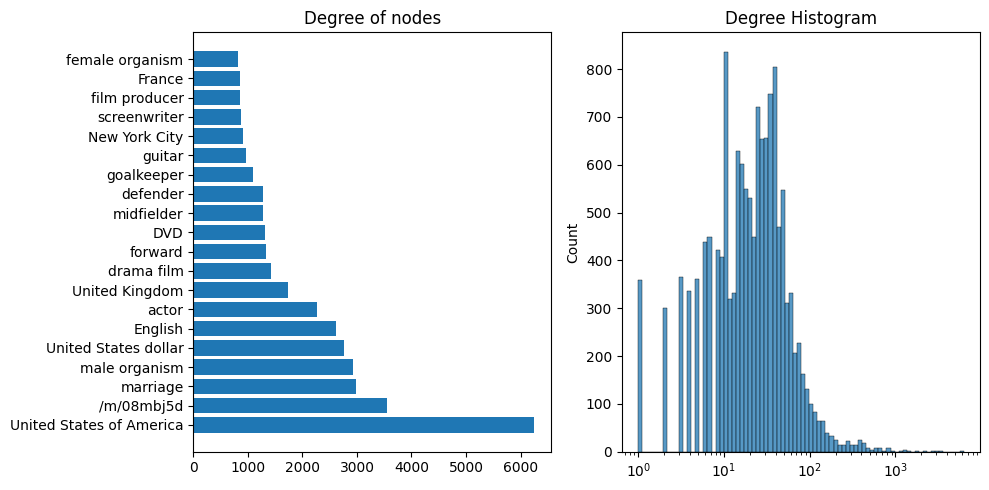

In [10]:
degree_sequence = sorted(g.degree(), key=lambda x: x[1], reverse=True)[:20]

x, y = zip(*degree_sequence)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Degree of nodes")
axes[0].barh(y=x, width=y)
axes[1].set_title("Degree Histogram")
sns.histplot([d for n, d in g.degree()], ax=axes[1], log_scale=True)
plt.tight_layout()

## Training 

In [11]:
result = pipeline(
    dataset=dataset,
    model="TransE",
    model_kwargs={"embedding_dim": 32},
    loss="nssa",
    loss_kwargs={"adversarial_temperature": 0.34, "margin": 9},
    optimizer="Adam",
    optimizer_kwargs={"lr": 0.004},
    negative_sampler_kwargs={"num_negs_per_pos": 33},
    training_kwargs=dict(
        num_epochs=20,
        batch_size=512,
        use_tqdm_batch=False,
    ),
    random_seed=123,
)

Training epochs on cpu:   0%|          | 0/20 [00:00<?, ?epoch/s]

Evaluating on cpu:   0%|          | 0.00/20.4k [00:00<?, ?triple/s]

In [12]:
save_location = Path("results/FB15k237")
save_location.mkdir(exist_ok=True, parents=True)
result.save_to_directory(save_location)
print(f"Saved: {os.listdir(save_location)}")

Saved: ['trained_model.pkl', 'results.json', 'training_triples', 'metadata.json']

## Metrics

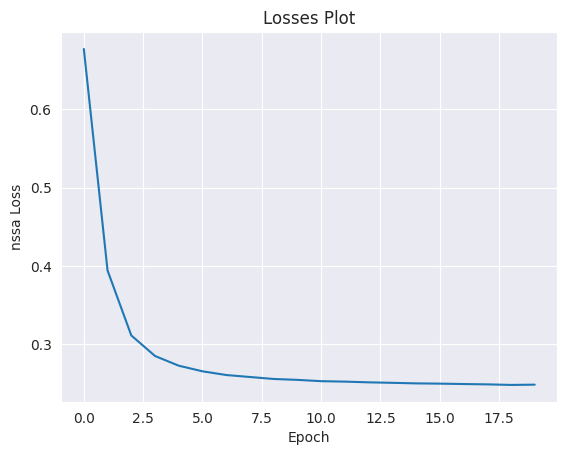

In [13]:
result.plot_losses()
plt.show()

In [14]:
metrics = result.metric_results.to_df()

In [15]:
metrics[(metrics.Side == "both") & (metrics.Type == "realistic")]

,Side,Type,Metric,Value
5,both,realistic,geometric_mean_rank,29.41476
14,both,realistic,adjusted_arithmetic_mean_rank,0.03533
23,both,realistic,standard_deviation,651.45160
32,both,realistic,inverse_arithmetic_mean_rank,0.00404
41,both,realistic,inverse_median_rank,0.03571
50,both,realistic,inverse_harmonic_mean_rank,0.20696
59,both,realistic,z_arithmetic_mean_rank,337.36444
68,both,realistic,median_rank,28.00000
77,both,realistic,harmonic_mean_rank,4.83190
86,both,realistic,arithmetic_mean_rank,247.34822


## Embeddings visualization

In [16]:
model = result.model
model

TransE(
  (loss): NSSALoss()
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(14233, 32)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(237, 32)
    )
  )
  (weight_regularizers): ModuleList()
)

In [17]:
embeddings = result.model.entity_representations[0](torch.arange(dataset.num_entities))
labels = [dataset.training.entity_id_to_label[i] for i in range(dataset.num_entities)]

In [18]:
prepare_for_visualization(embeddings.detach().numpy(), labels, Path("logs/FB15k237"))

In [19]:
!tensorboard --logdir=logs/FB15k237


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


## Ćwiczenie

Napisz funckję predykcji dla modelu TransE bez korzystania z pyKEEN. Ma ona drukować 10 najbliższych sąsiadów pasujących do zapytania (h, r, ?). 
Zastosuj poniższy wzór do liczenia dystansu miedzy wektorami. Gdzie $sum$ to funkcja sumująca wszytskie elementy.
$$d = sum((a - b)^2)$$

Podpowiedzi:
1. Wektory encji znajdują się pod `result.model.entity_representations`.
2. Wektory relacji znajdują się pod `result.model.relation_representations`.
3. Niezbędne słowniki pod: `dataset.training.relation_to_id`, `dataset.training.entity_to_id`, `dataset.training.entity_id_to_label`.
4. TransE opiera się na założeniu: $$h+r=t$$

In [25]:
result.model.eval()


@interact
def predict(
    head=list(sorted(dataset.training.entity_id_to_label.values())),
    relation=list(sorted(dataset.training.relation_id_to_label.values())),
):
    print(f"{head}, {relation}, ?")

    e_id = dataset.training.entity_to_id[head]
    rel_id = dataset.training.relation_to_id[relation]

    emb_ent = embeddings[e_id]
    emb_rel = result.model.relation_representations[0](torch.tensor([rel_id]))
    print((emb_ent + emb_rel - embeddings).shape)
    dist = ((emb_ent + emb_rel - embeddings) ** 2).sum(dim=-1)

    _, idx = torch.topk(dist, 10, largest=False)
    for num, i in enumerate(idx):
        print(f"{num}. {dataset.training.entity_id_to_label[i.item()]}")

interactive(children=(Dropdown(description='head', options=("'N Sync", '(+/-)-pantothenic acid', '(500) Days o…